The above header is for creating a nicely-formatted `.html` and `.pdf` documents using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html` and `.pdf` versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-38.ipynb && open dissipation-theory--Study-38.html

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-38.ipynb`
- Continued from: `dissipation-theory--Study-29.ipynb` and `dissipation-theory--Study-34.ipynb`
- Continued to: ---

# Preliminaries

In [1]:
import numpy as np
import pandas

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [42]:
THIS = 'dissipation-theory--Study-38--'
figs = {}

In [4]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation5 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation5 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation5 import theta1norm, gamma_perpendicular
from dissipationtheory.dissipation5 import theta1norm_jit, gamma_perpendicular_jit
from dissipationtheory.dissipation5 import blds_perpendicular, blds_perpendicular_jit
from dissipationtheory.dissipation5 import BLDSzerolow, BLDSzerohigh

# Set up the cantilever

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degrees'),
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [6]:
cantilever

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

In [7]:
cantilever.args()

{'f_c': 75000.0,
 'k_c': 2.8,
 'V_ts': 1,
 'R': 3.5e-08,
 'angle': 20,
 'd': 3.8e-08,
 'z_c': 7.3e-08}

# Mimic a thick perovskite sample

Take parameters from the Table 1.D sample in our "BLDS paper" manuscript, except make the sample thicker.

In [8]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

In [9]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),
    sigma = sigma, # we will reset this below
    rho = rho,     # we will reset this below
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(7300, 'nm')
)

In [10]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 20.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 6.242e+21 m^{-3}
           reference height = 7.300e+03 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 1.000e-08 m^2/(V s)
         diffusion constant = 2.585e-10 m^2/s
               Debye length = 1.513e+01 nm
           diffusion length = 2.342e+01 nm
   effective epsilon (real) = 20.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

In [11]:
sample1_jit = SampleModel1Jit(**sample1.args())
sample1_jit.print()

cantilever
        cantilever freq =  75000.0 Hz
                        =  471238.89803846896 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.5e-08 m
        cone half angle =  20.0 degree
                 height =  3.8e-08 m
  tip charge z location =  7.3e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  7.3e-06 m
            conductivity =  1e-05 S/m
          charge density =  6.241509090043338e+21 m^{{-3}}
        reference height =  7.3e-06 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  1e-08 m^2/(V s)
      diffusion constant =  2.585199985097773e-10 m^2/s
            Debye length =  1.5129390669059825e-08 m
        diffusion length =  2.3422136438546186e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.596680477936312

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinit

# Example friction calculation

Spot-check the new friction-calculation code by comparing a numba/jit result to a pure-Python result.

First, the numba/jit result.

In [12]:
%%time
ans1a = gamma_perpendicular_jit(theta1norm_jit, sample1_jit)
ans1a

CPU times: user 4.99 ms, sys: 1.15 ms, total: 6.14 ms
Wall time: 19.4 ms


<Quantity(0.33851655364224437, 'piconewton * second / meter')>

Now the pure Python result.

In [13]:
%%time
ans1b = gamma_perpendicular(theta1norm, sample1)
ans1b

CPU times: user 1.64 s, sys: 22.5 ms, total: 1.67 s
Wall time: 1.79 s


<Quantity(0.33851655364224476, 'piconewton * second / meter')>

# Example BLDS calculation

## Compare Python and jit functions

Compare the execution time for pure-Python and numba/jit calculations.  Create are array of two $\omega_{\mathrm{m}}$ values.

In [14]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 8, 2), 'Hz')
omega_m

Magnitude,[62.83185307179586 628318530.7179586]
Units,hertz


In [15]:
%%time
ans2a = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m)
ans2a 

CPU times: user 5.53 ms, sys: 264 µs, total: 5.79 ms
Wall time: 9.06 ms


Magnitude,[-1.0906258299024583 -1.0613973206130325]
Units,hertz


In [16]:
%%time
ans2b = blds_perpendicular(theta1norm, sample1, omega_m)
ans2b 

CPU times: user 3.28 s, sys: 37 ms, total: 3.31 s
Wall time: 3.53 s


Magnitude,[-1.0906258299024585 -1.061397320613033]
Units,hertz


## Compare old and new functions

In [17]:
from dissipationtheory.dissipation4 import CantileverModel as CantileverModel_v4
from dissipationtheory.dissipation4 import SampleModel1 as SampleModel1_v4
from dissipationtheory.dissipation4 import SampleModel1Jit as SampleModel1Jit_v4
from dissipationtheory.dissipation4 import theta1norm_jit as theta1norm_jit_v4
from dissipationtheory.dissipation4 import blds_perpendicular_jit as blds_perpendicular_jit_v4

Make a comparable "old" sample.

In [18]:
cantilever_v4 = CantileverModel_v4(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

sample1_v4 = SampleModel1_v4(
    cantilever = cantilever_v4,
    h_s = ureg.Quantity(7300, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),
    sigma = ureg.Quantity(1E-5, 'S/m'),                 # we will reset this below
    rho = ureg.Quantity(1e21, '1/m^3'),                 # we will reset this below
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(7300, 'nm')
)

sample1_jit_v4 = SampleModel1Jit_v4(**sample1_v4.args())

Now run the calculation.

In [19]:
ans2c = blds_perpendicular_jit_v4(theta1norm_jit_v4, sample1_jit_v4, omega_m)
ans2c.sum(axis=1) 

Magnitude,[-2.884654361839785 -2.806699514653444]
Units,hertz


<div class="alert alert-block alert-success">
The new BLDS frequency shift is less than half the old BLDS frequency shift.  
</div>

This makes sense, for two reasons. (1) The tip charge used in the new calculation, $q_0 = 4 \pi \epsilon_0 R \: V_{\mathrm{tip}}$, is smaller than the charge used in the old calculation, $q = C \: V_{\mathrm{tip}}$, where the capacitance $C$ was computed numerically.  (2) The new calculation of the BLDS frequency shift contains only a $K_2$ term, whereas the old calculation involved constributions from $K_0$, $K_1$, and $K_2$ terms (all the same sign).


# Vary charge density and compute friction and BLDS frequency shift

Set up an array of modulation frequencies and an array of conductivities.

For code development, set

* `N_omega` = 10
* `N_sigma` = 10

To make paper-quality figures, rerun with

* `N_omega` = 100
* `N_sigma` = 200

In [20]:
N_omega = 100
N_sigma = 200

In [21]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [22]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [23]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [24]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.  Add to the data 

* a scaled BLDS frequency axis, $\Omega_{\mathrm{m}} \equiv (\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}})/\omega_0$ or `omega_m scaled`

* a scaled charge density axis, $\hat{\rho}_1 \equiv z_{\mathrm{c}}^2 / \lambda_{\mathrm{D}}^2$ or `rho scaled 1`

* a second scaled charge density axis, $\hat{\rho}_2 \equiv z_{\mathrm{c}}^2 / (\epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}}^2)$ or `rho scaled 2`

* a scaled frequency axis $\Omega_0 \equiv \omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$ or `omega_c scaled`

with

\begin{equation}
\lambda_{\mathrm{D}}^2 \equiv \frac{\epsilon_0 k_{\mathrm{B}} T}{e^2 \rho}
\end{equation}

the Debye length and $z_{\mathrm{c}}$ the sample-to-tip-charge separation.

In [25]:
def calculate(sample1_jit, omega_m, rho, sigma):
    
    data = {}
    for rho_, sigma_ in zip(rho, sigma):

        sample1_jit.rho = rho_.to('1/m^3').magnitude
        sample1_jit.sigma = sigma_.to('S/m').magnitude
    
        gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
        f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
        
        ep = sample1_jit.epsilon_s.real   
        z_c = ureg.Quantity(sample1_jit.cantilever.z_c, 'm')
        LD = ureg.Quantity(sample1_jit.LD, 'm')
        rho = ureg.Quantity(sample1_jit.rho, '1/m^3')
        omega_0 = (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')
        omega_c = ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz')
    
        data[str(sigma_.to('S/m').magnitude)] = {
            'sample': sample1_jit,
            'omega_0': omega_0,
            'omega_m': omega_m,
            'omega_m scaled': ((ep * omega_m)/omega_0).to('').magnitude,
            'f_BLDS': f_BLDS, 
            'gamma': gamma,
            'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
            'z_c': z_c,
            'LD': LD,
            'rho': rho,
            'rho scaled 1': (z_c**2/(     LD**2)).to('').magnitude,
            'rho scaled 2': (z_c**2/(ep * LD**2)).to('').magnitude,
            'omega_c': omega_c,
            'omega_c scaled': (omega_0/(ep * omega_c)).to('').magnitude}

    return data

In [26]:
%%time

data['01'] = calculate(sample1_jit, omega_m__array, rho__array, sigma__array)

CPU times: user 26.3 s, sys: 338 ms, total: 26.6 s
Wall time: 32.6 s


## Plot the BLDS spectra

A helper plotting function.

In [28]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                data[key]['f_BLDS'].to('Hz').magnitude,
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('$\Delta f_{\mathrm{BLDS}}$ [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 5th BLDS spectrum.

In [29]:
data['01-short'] = {}
for key in list(data['01'].keys())[::5]:
    data['01-short'][key] = data['01'][key]

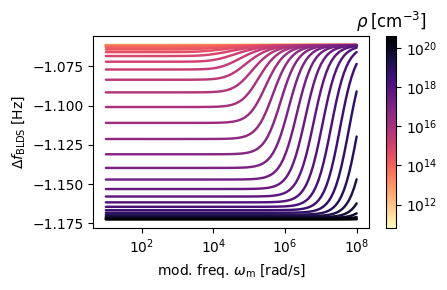

In [43]:
#| label: fig-blds
#| fig-cap: | 
#|   Broadband local dielectric spectrum of thick lead-halide perovskite 
#|   semiconductor versus charge density.

figs['01'] = plotBLDS(data['01-short'])

Define a function to plot the BLDS spectra versus a scaled frequency.

In [31]:
def plotBLDSscaled(data, sample1):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        x = data[key]['omega_m scaled']
        y = data[key]['f_BLDS'].to('Hz').magnitude
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(x, y, '-', color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    # vertical line
    (ymax, ymin) = (BLDSzerolow(sample1,0), BLDSzerohigh(sample1,0))    
    plt.vlines(1.0, ymin, ymax, colors='tab:gray', linestyles='dashed') # hardwired, ugh
    
    plt.xlim(1e-2,1e2)
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('scaled modulation freq. $\Omega_{\mathrm{m}} = '
               '(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}})/\omega_0$')
    plt.tight_layout()
    plt.show()
    
    return fig

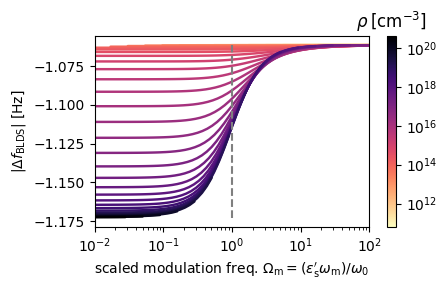

In [44]:
figs['02'] = plotBLDSscaled(data['01-short'], sample1)

## Plot the BLDS spectrum at zero frequency versus charge density

In [33]:
def plotBLDSzero(data):
    
    # generate arrays for plotting
    
    rho = np.zeros(len(data))
    rho_scaled = np.zeros(len(data)) 
    BLDS0 = np.zeros(len(data)) 
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        rho_scaled[index] = data[key]['rho scaled 2']
        BLDS0[index] = data[key]['f_BLDS'][0].to('Hz').magnitude
    
    # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again
    
    rho0 = (rho/rho_scaled)[0]
    
    def fwd(x):
        return x*rho0

    def rev(rho):
        return rho/rho0   
    
    # now plot
    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.0))
    
    with plt.style.context('seaborn-v0_8'):
        ax.semilogx(rho_scaled, BLDS0)

    axT = ax.secondary_xaxis("top", functions=(fwd,rev))
        
    plt.vlines(1.0, BLDS0.min(), BLDS0.max(), colors='tab:gray', linestyles='dashed')        
    ax.set_ylabel(r'$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$ [Hz]')
    ax.set_xlabel(r'scaled charge density $\hat{\rho} = z_{\mathrm{c}}^2/(\epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}}^2)$')
    axT.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.grid()
    plt.tight_layout()
    
    return fig

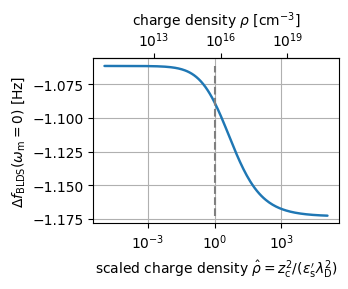

In [45]:
figs['03'] = plotBLDSzero(data['01'])

# Check the integrand $\theta_1$

In [35]:
from dissipationtheory.dissipation5 import theta1norm as theta1norm_v5
from dissipationtheory.dissipation4 import theta1norm as theta1norm_v4

In [36]:
print(theta1norm_v5(10., sample1, ureg.Quantity(1e5, 'Hz'), 2, part=np.real))

75.88184199290572


In [37]:
print(theta1norm_v4(10., sample1, ureg.Quantity(1e5, 'Hz'), 2, part=np.real))

75.88184199290572


# Check the function K

In [38]:
from dissipationtheory.dissipation5 import K as K_v5
from dissipationtheory.dissipation4 import K as K_v4

In [39]:
K_v5(2, theta1norm_v5, sample1, ureg.Quantity(1e5, 'Hz'), part=np.real)

<Quantity(5.909302107185035e+20, '1 / meter ** 3')>

In [40]:
K_v4(2, theta1norm_v4, sample1, ureg.Quantity(1e5, 'Hz'), part=np.real)

<Quantity(5.909302107185035e+20, '1 / meter ** 3')>

# Conclusions

<div class="alert alert-block alert-danger">
The zero-frequency limit of the BLDS frequency shift, $\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}) = 0$, does not depend on the unitless scaled charge density, $\hat{\rho}_2 = z_{\mathrm{c}}^2 / (\epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}}^2)$, in the expected way. 
</div>

Based on what was observed in `dissipation-theory--Study-34.ipynb` (i.e., `Study-34`) for an identical sample, at $\hat{\rho}_2 = 1$ we expect $\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}} = 0)$ to be halfway between its limiting values.  Instead we see that $\Delta f_{\mathrm{BLDS}}(0)$ has reached its halfway point closer to $\hat{\rho}_2 \sim 10$ in the above example.  The difference between the `dissipation4.py` module used in `Study-34` and the `dissipation5.py` module used here is the computation of the BLDS frequency shift; the core computation of the $K_\ell$ integrals is the same in both modules.  Above I checked that the $K_2$ integral yields the same result (for one sample, and at one frequency) for both modules.  So I would expect to see the same dependence of $\Delta f_{\mathrm{BLDS}}(0)$ on $\hat{\rho}_2$ here.  

Is this difference due to a coding error?

Comparing `Study-34` to this notebook, observe that in the plot of $\Delta f_{\mathrm{BLDS}}(0)$ versus $\hat{\rho}_2$, the $x$ axis has a larger range in `Study-34`.  The range of charge density, and therefore unitless charge density, should be the same in both notebooks.  Puzzling.

# Next step

Make a copy of `dissipation-theory--Study-34.ipynb` called `dissipation-theory--Study-39.ipynb`.  In `Study-39` retain all the code, except (1) input from `dissipation5` instead of `dissipation4` and (2) update the cantilever object to have a cone angle.

# Save the figures

In [46]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')